In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException

import time

In [2]:
url = 'https://today.yougov.com/ratings/entertainment/popularity/all-time-actors-actresses/all'
path = "Path" # Path to webdriver executable

chrome_options = Options()
chrome_options.binary_location = r"C:\Program Files\Google\Chrome\Application\chrome.exe"

# Use only chrome_options, not executable_path
driver = webdriver.Chrome(options=chrome_options)

driver.get(url)


# Decline cookies settings
try:
    decline_button = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler'))
    )

    decline_button.click()
except Exception as e:
    pass

# Scroll down to load more data
while True:
    # Scroll to the bottom of the page
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)

    # Wait for a short interval to allow the content to load
    time.sleep(2)

    # Check if there are more actors loaded
    try:
        load_more_button = WebDriverWait(driver, 100).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'load-more-button'))
        )
        
        load_more_button.click()
    except TimeoutException:
        break

html = driver.page_source
driver.quit()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Element containing the list of actors
actors_container = soup.find('div', class_='rankings-entities-list-container')

# Actor's list items
actor_items = actors_container.find_all('li', class_='ng-star-inserted')

# Create lists to store data
actor_names = []
popularity_percentages = []
fame_percentages = []

for actor_item in actor_items:
    # Extract the actor name
    actor_name = actor_item.find('img', class_='ng-star-inserted')['alt'] if actor_item.find('img', class_='ng-star-inserted') else None

    # Extract popularity percentage
    popularity_element = actor_item.find('span', class_='compact')
    popularity_percentage = popularity_element.text.split('%')[0] if popularity_element else None

    # Extract fame percentage
    fame_element = actor_item.find('span', class_='rankings-item-active')
    fame_percentage = fame_element.text.split('%')[0] if fame_element else None

    actor_names.append(actor_name)
    popularity_percentages.append(popularity_percentage)
    fame_percentages.append(fame_percentage)

data = {
    'Actor Name': actor_names,
    'Popularity (%)': popularity_percentages,
    'Fame (%)': fame_percentages
}

famous_actors = pd.DataFrame(data)

print(famous_actors)
famous_actors.to_csv('../Data/preprocessed_data/famous_actors_db.csv', index=False)


KeyboardInterrupt: 

### 1. Find relationship between fame and popularity

In [21]:
actors_db = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
famous_actors_db = pd.read_csv('../Data/preprocessed_data/famous_actors_db.csv')

In [27]:
# Merge DataFrames on actor name
merged_data = pd.merge(actors_db, famous_actors_db, left_on='name', right_on='Actor Name', how='inner')

# Check for missing values
print(merged_data.isnull().sum())

# Calculate the correlation coefficient
correlation_coefficient = merged_data['Popularity (%)'].corr(merged_data['popularity'], method='pearson')
print(f'Correlation Coefficient: {correlation_coefficient}')

name                 0
gender               0
popularity           0
original_language    0
genre_ids            0
known_for            0
id                   0
Actor Name           0
Popularity (%)       0
Fame (%)             0
dtype: int64
Correlation Coefficient: 0.21853557565634227


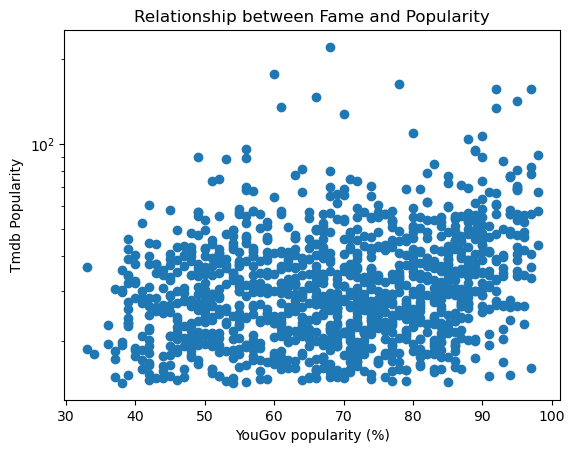

In [26]:
import matplotlib.pyplot as plt

# Not considered low
# Scatter plot
plt.scatter(merged_data['Popularity (%)'], merged_data['popularity'])
plt.xlabel('YouGov popularity (%)')
plt.ylabel('Tmdb Popularity')
plt.yscale('log')
plt.title('Relationship between Fame and Popularity')
plt.show()


Unfortunately, we cannot conclude a relationship between fame and popularity. We originally wanted to explore the relationship between fame and popularity for actors who have both features and determine if it's reasonable to extend the fame feature to other actors.  
But following the results we obtained, the correlation coefficient that is too weak (0.2) and the graph showing the relationship between both, we cannot conclude this latter.

## Movie trajectory for actors

In [1]:
# extract a json file and transform it into a dataframe
import requests
import pandas as pd
import json

tmdb_id2credit = json.load(open('../Data/tmdb_resources/tmdb_id2credit_full.json'))
id2credit_df = pd.DataFrame.from_dict(tmdb_id2credit, orient='index')
id2credit_df = id2credit_df.drop(columns='crew')

tmdb_id2credit_imdb_rating = json.load(open('../Data/tmdb_resources/tmdb_id2detail_imdb_rating.json'))
imdb_rating_df = pd.DataFrame.from_dict(tmdb_id2credit_imdb_rating, orient='index')

In [2]:
columns_to_keep = ['id', 'original_title', 'release_date', 'original_language', 'genres', 'budget', 'revenue', 'imdb_average_rating']
imdb_rating_filtered_df = imdb_rating_df[columns_to_keep]
imdb_rating_filtered_df.reset_index(drop=True, inplace=True)

# Creating a dataframe with revenue that is different from 0
revenue_non_zero_df = imdb_rating_filtered_df[imdb_rating_filtered_df['revenue'] != 0]
print(f'The number of movies with revenue is {revenue_non_zero_df.shape[0]:,}')

# Creating a dataframe with imdb_average_rating different from NaN
rating_not_nan_df = imdb_rating_filtered_df.dropna(subset=['imdb_average_rating'])
print(f'The number of movies with imdb ratings is {rating_not_nan_df.shape[0]:,}')

# Display the updated DataFrame
display(imdb_rating_filtered_df)

The number of movies with revenue is 18,904
The number of movies with imdb ratings is 393,909


,id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8
...,...,...,...,...,...,...,...,...
863077,1096279,Eva,2021-01-01,id,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN
863078,1001995,勾魂令,2018-02-02,zh,"[{'id': 27, 'name': 'Horror'}]",0,0,NaN
863079,823988,La Voix Humaine / L’Heure Espagnole,2021-03-26,en,[],0,0,NaN
863080,1022210,How Science Changed Our World,2010-12-23,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN


Cast preprocessing

In [3]:
# Assuming 'id' is the common column between imdb_rating_filtered_df and id2credits
merged_df = pd.merge(imdb_rating_filtered_df, id2credit_df, on='id', how='inner')

# Filter rows with either revenue not equal to 0 or imdb_average_rating not NaN
merged_df_filtered = merged_df[(merged_df['revenue'] != 0) | (~merged_df['imdb_average_rating'].isna())]
merged_df_filtered.reset_index(drop=True, inplace=True)
merged_df_filtered = merged_df_filtered.rename(columns={'id': 'movie_id'})


# Now, you can use merged_df_filtered for further analysis or display the desired information
print(f'The number of movies with revenue or imdb ratings is {merged_df_filtered.shape[0]:,}')
display(merged_df_filtered)

The number of movies with revenue or imdb ratings is 396,556


,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating,cast
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9,"[{'adult': False, 'gender': 1, 'id': 57395, 'k..."
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8,"[{'adult': False, 'gender': 2, 'id': 1086663, ..."
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2,"[{'adult': False, 'gender': 1, 'id': 46948, 'k..."
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1,"[{'adult': False, 'gender': 2, 'id': 18181, 'k..."
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8,"[{'adult': False, 'gender': 2, 'id': 10922, 'k..."
...,...,...,...,...,...,...,...,...,...
396551,770135,Scandal in 97,2020-11-29,en,"[{'id': 53, 'name': 'Thriller'}]",0,0,4.9,"[{'adult': False, 'gender': 2, 'id': 1232652, ..."
396552,472471,Sniff!!!,2017-08-25,hi,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",0,0,5.3,"[{'adult': False, 'gender': 0, 'id': 1963881, ..."
396553,707790,マッハ’78,1978-02-25,ja,"[{'id': 28, 'name': 'Action'}]",0,0,6.1,"[{'adult': False, 'gender': 0, 'id': 2767640, ..."
396554,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8,"[{'adult': False, 'gender': 2, 'id': 91251, 'k..."


In [6]:
import pandas as pd

def get_cast_dataframe(movie_id):
    cast = merged_df_filtered[merged_df_filtered['movie_id'] == movie_id]['cast'].values[0]
    #cast_df = pd.DataFrame(cast.tolist()).explode('cast', ignore_index=True)
    return cast

result_df = get_cast_dataframe(267899)
print(result_df)


[{'adult': False, 'gender': 2, 'id': 91251, 'known_for_department': 'Acting', 'name': 'Luis Fernando Peña', 'original_name': 'Luis Fernando Peña', 'popularity': 3.955, 'profile_path': '/1nooPX0s6Qi03Npt1Wr9AK7gE08.jpg', 'cast_id': 1, 'character': 'Francisco', 'credit_id': '5363fff80e0a261df800373d', 'order': 0}, {'adult': False, 'gender': 0, 'id': 1316106, 'known_for_department': 'Acting', 'name': 'Alejandra Guinea', 'original_name': 'Alejandra Guinea', 'popularity': 0.6, 'profile_path': None, 'cast_id': 2, 'character': 'Adela', 'credit_id': '536400090e0a261dfb003760', 'order': 1}, {'adult': False, 'gender': 0, 'id': 1316107, 'known_for_department': 'Acting', 'name': 'Mariana Urritia', 'original_name': 'Mariana Urritia', 'popularity': 0.6, 'profile_path': None, 'cast_id': 3, 'character': 'Xochitl', 'credit_id': '536400210e0a261dfb00376b', 'order': 2}, {'adult': False, 'gender': 0, 'id': 1316108, 'known_for_department': 'Acting', 'name': 'Francisco Cardoso', 'original_name': 'Francisco 

Movie detail has revenue and imdb ratings   
Movie credits has movie-actor pair data  

**Objective**: Given an actor's id, return a plot with an x axis of the movies they appread in sorted by year and a y axis of the movies' ratings.


In [6]:
def get_movies_by_actor(actor_id):
    """
    Retrieves a subset of movies from the DataFrame based on a specified actor_id,
    including the order of the actor in each movie.

    Parameters:
    - actor_id (int): The ID of the actor to filter movies by.

    Returns:
    - String: The name of the actor.
    - DataFrame: A subset of the original DataFrame containing only the movies
      where the specified actor is part of the cast, along with the 'order' column
      indicating the actor's order in each movie.
    """

    filtered_df = merged_df_filtered[
        merged_df_filtered['cast'].apply(
            lambda cast: any(
                actor_id == actor.get('id', '')
                for actor in cast
            )
        )
    ]
    filtered_df['order'] = filtered_df['cast'].apply(
        lambda cast: next(
            actor.get('order', '')
            for actor in cast
            if actor_id == actor.get('id', '')
        )
    )

    # set the indices to normal
    filtered_df.reset_index(drop=True, inplace=True)

    if not filtered_df['cast'].empty:
        actor_name = filtered_df['cast'].apply(
            lambda cast: next(
                actor.get('name', '')
                for actor in cast
                if actor_id == actor.get('id', '')
            )
        ).values[0]
    else:
        actor_name = ''
    return actor_name, filtered_df


In [47]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def divided_movies(actor_movies):
    first_part, second_part, third_part = get_movies_sections(actor_movies)
    return first_part['release_date'].max(), second_part['release_date'].max()

def get_movies_sections(actor_movies):
    num_movies = len(actor_movies)
    movies_per_part = num_movies // 3
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    first_part = actor_movies_sorted[:movies_per_part]
    second_part = actor_movies_sorted[movies_per_part:2 * movies_per_part]
    third_part = actor_movies_sorted[2 * movies_per_part:]

    return first_part, second_part, third_part

def plot_movies_ratings(actor_id):
    actor_name, actor_movies = get_movies_by_actor(actor_id)
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    # Determine dates at which the parts change
    date_beginning, date_middle = divided_movies(actor_movies)
    actor_movies_sorted['genres_str'] = actor_movies_sorted['genres'].apply(lambda genres: ', '.join([genre['name'] for genre in genres]) if genres else '')

    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title', 'genres_str', 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'genres_str': 'Genres', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}')
    
    rgba_light_yellow = (255, 255, 100, 0.5)  # light yellow
    rgba_light_orange = (255, 165, 0, 0.5)    # light orange
    rgba_light_red = (240, 128, 128, 0.5)      # light red

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=actor_movies_sorted['release_date'].min(),
            x1=date_beginning,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_yellow}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_beginning,
            x1=date_middle,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_orange}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_middle,
            x1=actor_movies_sorted['release_date'].max(),
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_red}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    # Set specific colors for the 'order' column
    fig.update_traces(marker=dict(color=actor_movies_sorted['order'].map({
        0: 'red', 1: 'red',
        2: 'yellowgreen', 3: 'yellowgreen', 4: 'yellowgreen', 5: 'yellowgreen',
        # Add more mappings for other orders as needed
    })))

    fig.show()

plot_movies_ratings(1373737)
plot_movies_ratings(10922)
plot_movies_ratings(62644)

KeyboardInterrupt: 

In [32]:
# how many movies appeared before 1950
# if the date exists, then check if it is before 1950
# if the date doesn't exist, then it is before 1950
# if the date is after 1950, then it is not before 1950

print(f'The number of all movies is {merged_df_filtered.shape[0]:,}')
filter = merged_df_filtered['release_date'].apply(lambda date: date < '1950-01-01' if date else False)
# suppress all rows that have a release date before 1950
merged_df_filtered_f = merged_df_filtered[~filter]
merged_df_filtered_f.reset_index(drop=True, inplace=True)
print(f'The number of movies after 1980 is {merged_df_filtered_f.shape[0]:,}')
print(f'The number of movies before 1980 is {merged_df_filtered.shape[0] - merged_df_filtered_f.shape[0]:,}')


The number of all movies is 396,556
The number of movies after 1980 is 359,122
The number of movies before 1980 is 37,434


In [ ]:
import matplotlib.pyplot as plt

json_data = json.load(open('../Data/tmdb_resources/tmdb_actors_db.json'))
tmdb_actors = pd.json_normalize(json_data['results'], sep='_')
# only keep 100 first actors
tmdb_actors = tmdb_actors[:1000]

# plot length of actor's career (last movie date - first movie date)
# length of 
career_lengths = []
for actor_id in tmdb_actors['id']:
    actor_name, actor_movies = get_movies_by_actor(actor_id)
    actor_movies_sorted = actor_movies.sort_values(by='release_date')
    if len(actor_movies_sorted) > 0:
        # get the difference in year only. actor_movies_sorted['release_date'].max() is a string in the format 'YYYY-MM-DD'
        last_movie_year = actor_movies_sorted['release_date'].max()[:4]
        first_movie_year = actor_movies_sorted['release_date'].min()[:4]

        # Check if the strings are not empty before converting to int
        if last_movie_year and first_movie_year:
            # transform to int
            last_movie_year = int(last_movie_year)
            first_movie_year = int(first_movie_year)
            # calculate the career length and append to the list
            career_lengths.append(last_movie_year - first_movie_year)
        else:
            # Handle the case where either last_movie_year_str or first_movie_year_str is empty
            print("Error: Release date strings are empty.")

# separate career with length
# separate people with career length [0.20], [20,40] and [40, onwards]
# will do the analysis 3 times for example
            

# plot the career lengths 
plt.figure(figsize=(20, 6))
plt.hist(career_lengths, bins=20)
plt.title('Distribution of career lengths')
plt.xlabel('Career length (years)')
plt.ylabel('Number of actors')
plt.show()

Add frequency of movies per year

In [14]:
def get_average_features(actor_movies):
    if not actor_movies['genres'].empty:
        first_part, second_part, third_part = get_movies_sections(actor_movies)
        first_part_average = first_part[['imdb_average_rating', 'order']].mean()
        second_part_average = second_part[['imdb_average_rating', 'order']].mean()
        third_part_average = third_part[['imdb_average_rating', 'order']].mean()

        if not first_part['genres'].empty:
            first_part_average['genres'] = ', '.join([genre['name'] for genre in first_part['genres'].values[0]])
        else:
            return ''
        if not second_part['genres'].empty:
            second_part_average['genres'] = ', '.join([genre['name'] for genre in second_part['genres'].values[0]])
        else:
            return ''
        if not third_part['genres'].empty:
            third_part_average['genres'] = ', '.join([genre['name'] for genre in third_part['genres'].values[0]])
        else:
            return ''

        average_data = pd.DataFrame([first_part_average, second_part_average, third_part_average], columns=['imdb_average_rating', 'order', 'genres'])
        #average_data['Career stage'] = ['Beginning', 'Middle', 'End/Current']
        #average_data = average_data.set_index('Career stage')
    else:
        # Handle the case where the DataFrame is empty
        return pd.Series({'imdb_average_rating': 0, 'order': 0, 'genres': ''})

    return average_data

In [15]:
get_average_features(get_movies_by_actor(1373737)[1])

C:\Users\anejj\AppData\Local\Temp\ipykernel_9376\426719220.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,imdb_average_rating,order,genres
0,6.600000,4.428571,"Drama, Mystery, Horror"
1,6.728571,0.714286,Horror
2,7.088889,9.000000,Documentary


C:\Users\anejj\AppData\Local\Temp\ipykernel_9376\426719220.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anejj\AppData\Local\Temp\ipykernel_9376\426719220.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anejj\AppData\Local\Temp\ipykernel_9376\426719220.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,imdb_average_rating,order
0,6.265495,5.769647
1,6.450038,5.432772
2,6.371492,6.137334


c:\Users\anejj\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\anejj\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\anejj\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\anejj\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\anejj\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version.

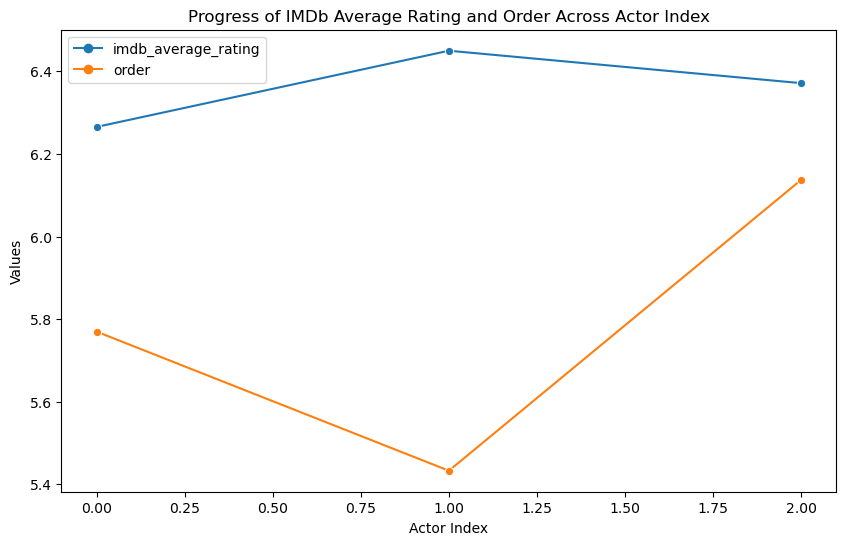

In [50]:
# get_average_features(get_movies_by_actor(actor_id)[1]) returns a DataFrame with the average IMDb rating and order of the movies for the specified actor
# i need to get the average of the average ratings of all the actors
# i need to get the average of the average orders of all the actors

# i can access the ids of actors through this dataframe tmdb_actors in the column 'id'.
# then i need to call the function get_average_features(get_movies_by_actor(actor_id)[1]) for each actor id
# and then i need to get the average of the average ratings and orders of all the actors
# then i need to plot this average growth of the average ratings and orders of all the actors

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming get_movies_by_actor and get_average_features functions are defined

# Load tmdb_actors DataFrame
json_data = json.load(open('../Data/tmdb_resources/tmdb_actors_db.json'))
tmdb_actors = pd.json_normalize(json_data['results'], sep='_')
# only keep 100 first actors
tmdb_actors = tmdb_actors[:100]



# Initialize empty DataFrame with lists
result_df = pd.DataFrame([[[], []], [[], []], [[], []]], columns=['imdb_average_rating', 'order'])

# Iterate through actor IDs
for actor_id in tmdb_actors['id']:
    # Get movies and calculate average features
    movies_by_actor = get_movies_by_actor(actor_id)[1]
    # if there are less than 3 movies, skip this actor
    if movies_by_actor.shape[0] < 3:
        continue
    average_features = get_average_features(movies_by_actor)

    # If average_features contains NaN values, skip this actor
    if average_features.isnull().values.any() or average_features.empty:
        continue

    avg_features = average_features['imdb_average_rating']
    avg_order = average_features['order']

    # Append the average IMDb rating and order to the DataFrame
    result_df['imdb_average_rating'].iloc[0].append(avg_features[0])
    result_df['imdb_average_rating'].iloc[1].append(avg_features[1])
    result_df['imdb_average_rating'].iloc[2].append(avg_features[2])
    result_df['order'].iloc[0].append(avg_order[0])
    result_df['order'].iloc[1].append(avg_order[1])
    result_df['order'].iloc[2].append(avg_order[2])

# Calculate the overall average IMDb rating and order
result_df['imdb_average_rating'] = result_df['imdb_average_rating'].apply(lambda x: np.mean(x))
result_df['order'] = result_df['order'].apply(lambda x: np.mean(x))

display(result_df)

plt.figure(figsize=(10, 6))

# Plotting the smooth lines using seaborn
sns.lineplot(data=result_df[['imdb_average_rating', 'order']], dashes=False, markers='o')

# Adding labels and title
plt.xlabel('Actor Index')
plt.ylabel('Values')
plt.title('Progress of IMDb Average Rating and Order Across Actor Index')

# Display the plot
plt.show()


## Dividing datasets

Divide the dataset into 3 
Features:
- Career length
Averages:
- order
- budget
- revenue
- tmdb popularity of movies
- imdb ratings of movies
- tmb vote average

order, budget, revenue, career length, tmdb popularity of movies, tmdb vote average, number of movies, popularity of actor

In [4]:
# transform acting_in_2003_and_later.csv into a dataframe
actors_df = pd.read_csv('../Data/preprocessed_data/acting_in_2003_and_later.csv')
display(actors_df)

,name,genre_mean_weighted,number_of_movies
0,Gary Oldman,['Crime'],32.0
1,Jason Statham,['Science Fiction'],20.0
2,Jackie Chan,['Crime'],36.0
3,Scarlett Johansson,['Science Fiction'],23.0
4,Josh Hutcherson,['Science Fiction'],13.0
...,...,...,...
5841,John Shea,['Music'],4.0
5842,Lyle Lovett,['War'],6.0
5843,Michael Maloney,['Comedy'],5.0
5844,Peter Cullen,['Science Fiction'],12.0


In [56]:

# Creating full_actors_df DataFrame
full_actors_list = []

for _, row in merged_df_filtered.iterrows():
    for actor_info in row['cast']:
        actor_entry = {
            'gender': actor_info['gender'],
            'actor_id': actor_info['id'],
            'name': actor_info['name'],
            'popularity': actor_info['popularity'],
            'character': actor_info['character'],
            'order': actor_info['order'],
            'movie_id': row['movie_id'],
            'original_title': row['original_title'],
            'release_date': row['release_date'],
            'original_language': row['original_language'],
            'genres': row['genres'],
            'budget': row['budget'],
            'revenue': row['revenue'],
            'imdb_average_rating': row['imdb_average_rating']
        }
        full_actors_list.append(actor_entry)

full_actors_df = pd.DataFrame(full_actors_list)

# Display the resulting full_actors_df
display(full_actors_df)


,gender,actor_id,name,popularity,character,order,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,1,57395,Natasha Henstridge,49.626,Lt. Melanie Ballard,0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,2,9778,Ice Cube,24.423,James 'Desolation' Williams,1,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
2,1,2230,Pam Grier,22.806,Commander Helena Braddock,2,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
3,2,976,Jason Statham,199.055,Sgt. Jericho Butler,3,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
4,1,20387,Clea DuVall,21.220,Bashira Kincaid,4,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009996,0,3836492,Cheryl Walde,0.600,,4,707790,マッハ’78,1978-02-25,ja,"[{'id': 28, 'name': 'Action'}]",0,0,6.1
4009997,2,91251,Luis Fernando Peña,3.955,Francisco,0,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8
4009998,0,1316106,Alejandra Guinea,0.600,Adela,1,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8
4009999,0,1316107,Mariana Urritia,0.600,Xochitl,2,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8


In [5]:
# display(full_actors_df)
#full_actors_df.to_csv('../Data/preprocessed_data/full_actors_db.csv', index=False)
full_actors_df = pd.read_csv('../Data/preprocessed_data/full_actors_db.csv')
display(full_actors_df)

,gender,actor_id,name,popularity,character,order,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,1,57395,Natasha Henstridge,49.626,Lt. Melanie Ballard,0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,2,9778,Ice Cube,24.423,James 'Desolation' Williams,1,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
2,1,2230,Pam Grier,22.806,Commander Helena Braddock,2,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
3,2,976,Jason Statham,199.055,Sgt. Jericho Butler,3,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
4,1,20387,Clea DuVall,21.220,Bashira Kincaid,4,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009996,0,3836492,Cheryl Walde,0.600,NaN,4,707790,マッハ’78,1978-02-25,ja,"[{'id': 28, 'name': 'Action'}]",0,0,6.1
4009997,2,91251,Luis Fernando Peña,3.955,Francisco,0,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8
4009998,0,1316106,Alejandra Guinea,0.600,Adela,1,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8
4009999,0,1316107,Mariana Urritia,0.600,Xochitl,2,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8


In [6]:
# remove rows where the imdb_average_rating is NaN
full_actors_df = full_actors_df.dropna(subset=['imdb_average_rating'])
# Filter full_actors_df to keep only the actors in actors_df
full_actors_df = full_actors_df[full_actors_df['name'].isin(actors_df['name'])]

full_actors_df.reset_index(drop=True, inplace=True)
display(full_actors_df)

,gender,actor_id,name,popularity,character,order,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,1,57395,Natasha Henstridge,49.626,Lt. Melanie Ballard,0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,2,9778,Ice Cube,24.423,James 'Desolation' Williams,1,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
2,1,2230,Pam Grier,22.806,Commander Helena Braddock,2,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
3,2,976,Jason Statham,199.055,Sgt. Jericho Butler,3,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
4,1,20387,Clea DuVall,21.220,Bashira Kincaid,4,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254582,1,146245,Kim Hye-soo,13.999,Sun-jae,0,64792,분홍신,2005-06-30,ko,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",0,0,5.8
254583,1,8857,Debbie Reynolds,20.281,Self (archive footage),8,844511,Sœur Sourire : Qui a tué la voix de Dieu ?,2021-06-11,fr,"[{'id': 99, 'name': 'Documentary'}, {'id': 104...",0,0,7.1
254584,1,164094,Marin Ireland,15.430,Anna,0,589496,Megafauna,2010-06-04,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",0,0,6.7
254585,2,58769,Stephen Colbert,4.737,Self (archive footage),12,376261,Weiner,2016-05-20,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,7.6


In [10]:
# regroup the actors by name and concatenate all their other features so that we have arrays in each one of them
import numpy as np
# Group the actors by name and concatenate all their other features
grouped_actors_df = full_actors_df.groupby('name').agg({
    # get the first element of gender, since it is the same for all rows
    'gender': lambda x: x.iloc[0],
    'popularity': lambda x: list(x),
    'release_date': lambda x: list(x),
    'genres': lambda x: list(x),
    'budget': lambda x: list(x),
    'revenue': lambda x: list(x),
    'imdb_average_rating': lambda x: list(x),
    'order': lambda x: list(x),
})

# Calculate the mean budget and revenue
mean_budget = full_actors_df['budget'].mean()
mean_revenue = full_actors_df['revenue'].mean()

# Replace the 0 values with the mean values
full_actors_df['budget'] = full_actors_df['budget'].replace(0, mean_budget)
full_actors_df['revenue'] = full_actors_df['revenue'].replace(0, mean_revenue)

grouped_actors_df['release_date'] = grouped_actors_df['release_date'].apply(
    lambda x: sorted([date for date in x if pd.notna(date)]) if isinstance(x, list) else [])
grouped_actors_df['career_length'] = grouped_actors_df['release_date'].apply(
    lambda x: int(x[-1][:4]) - int(x[0][:4]) if len(x) >= 2 and x[-1][:4] and x[0][:4] else 0)

#grouped_actors_df['career_length'] = grouped_actors_df['release_date'].apply(lambda x: int(x[-1][:4]) - int(x[0][:4]) if len(x) >= 2 and x[-1][:4] and x[0][:4] else 0)
display(grouped_actors_df)


,gender,popularity,release_date,genres,budget,revenue,imdb_average_rating,order,career_length
name,,,,,,,,,
50 Cent,2,"[14.999, 11.633, 10.69, 14.999, 10.69, 14.999,...","[2003-04-15, 2003-04-22, 2003-08-03, 2004-08-3...","[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...","[40000000.0, 11035527.421141144, 11035527.4211...","[60040976.0, 32901405.356068198, 32901405.3560...","[6.5, 5.4, 4.4, 4.6, 4.4, 5.6, 3.8, 4.4, 6.8, ...","[59, 1, 1, 0, 0, 2, 0, 0, 1, 4, 0, 1, 0, 0, 0,...",20
A Martinez,2,"[15.752, 11.636, 15.752, 11.636, 11.636, 11.63...","[1968-10-01, 1972-01-13, 1972-02-21, 1973-01-0...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...","[20000000.0, 11035527.421141144, 500000.0, 110...","[15400000.0, 32901405.356068198, 32901405.3560...","[5.7, 6.2, 3.0, 6.8, 6.7, 2.1, 5.7, 7.2, 5.8, ...","[6, 6, 2, 11, 4, 1, 5, 0, 1, 3, 3, 7, 15, 5, 1...",54
A.C. Peterson,2,"[18.63, 18.63, 18.63, 18.63, 18.63, 7.26, 18.6...","[1984-12-26, 1985-07-28, 1986-11-29, 1987-09-2...","[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...","[11000000.0, 11035527.421141144, 3500000.0, 11...","[4385312.0, 1733017.0, 44462.0, 4654288.0, 126...","[6.1, 5.9, 6.7, 5.3, 7.1, 5.4, 7.1, 6.0, 5.3, ...","[55, 32, 8, 11, 12, 18, 10, 8, 4, 5, 13, 10, 2...",37
A.J. Buckley,2,"[14.75, 9.655, 14.75, 14.75, 9.655, 14.75, 14....","[1998-07-24, 1999-05-18, 1999-10-17, 2000-07-1...","[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...","[1000000.0, 11035527.421141144, 1000000.0, 150...","[32901405.356068198, 32901405.356068198, 32901...","[4.6, 6.5, 5.8, 4.6, 3.7, 6.6, 5.6, 5.2, 5.3, ...","[1, 9, 4, 13, 5, 4, 11, 4, 9, 6, 1, 42, 7, 3, ...",20
A.J. Cook,1,"[25.15, 16.725, 25.15, 25.15, 25.15, 25.15, 16...","[1997-01-29, 1999-04-11, 1999-09-28, 1999-12-3...","[[{'id': 35, 'name': 'Comedy'}], [{'id': 35, '...","[24000000.0, 11035527.421141144, 11000000.0, 2...","[14782676.0, 32901405.356068198, 863044.0, 909...","[6.2, 5.7, 6.2, 6.2, 3.5, 4.0, 5.0, 4.3, 7.2, ...","[6, 4, 15, 0, 1, 8, 17, 4, 7, 0, 5, 12, 0, 0, ...",22
...,...,...,...,...,...,...,...,...,...
Ángela Molina,1,"[13.19, 23.747, 15.124, 13.19, 23.747, 13.19, ...","[1975-02-01, 1975-05-05, 1975-07-07, 1976-09-1...","[[{'id': 12, 'name': 'Adventure'}, {'id': 35, ...","[11035527.421141144, 11035527.421141144, 11035...","[13348704.0, 32901405.356068198, 32901405.3560...","[7.3, 5.6, 6.0, 7.4, 6.9, 6.2, 7.4, 6.4, 6.0, ...","[6, 2, 1, 8, 4, 4, 3, 4, 1, 1, 4, 1, 2, 1, 1, ...",48
Élodie Yung,1,"[19.373, 19.373, 19.373, 27.666, 24.22, 19.373...","[2004-06-23, 2007-06-20, 2008-11-19, 2009-02-1...","[[{'id': 53, 'name': 'Thriller'}, {'id': 80, '...","[90000000.0, 15000000.0, 130000000.0, 11035527...","[232617430.0, 8786375.0, 371876278.0, 32901405...","[7.8, 6.5, 5.7, 7.4, 6.4, 5.4, 4.6, 5.2, 4.4, ...","[60, 4, 6, 6, 5, 4, 7, 1, 1, 5, 6, 1, 6]",16
Óscar Jaenada,2,"[9.549, 9.549, 11.329, 9.549, 9.549, 11.329, 7...","[2001-01-05, 2003-09-12, 2003-09-26, 2004-08-2...","[[{'id': 18, 'name': 'Drama'}, {'id': 36, 'nam...","[40000000.0, 379000000.0, 11035527.421141144, ...","[8638163.0, 1045713802.0, 32901405.356068198, ...","[6.8, 6.6, 6.2, 4.9, 6.2, 6.1, 4.2, 6.0, 5.2, ...","[7, 12, 9, 11, 5, 6, 1, 0, 1, 0, 0, 0, 23, 0, ...",22


In [28]:
from datetime import datetime, timedelta

df = grouped_actors_df.copy()
# Convert release_date to a list of datetime objects
df['release_date'] = df['release_date'].apply(lambda x: [datetime.strptime(date, "%Y-%m-%d") for date in x])

# Calculate the time interval for each period
df['interval'] = (df['career_length'] // 3) * 365

# Initialize columns for date ranges
df['start_date_1'] = df.apply(lambda row: min(row['release_date']), axis=1)
df['end_date_1'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['start_date_2'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval']), axis=1)
df['end_date_2'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval'] * 2), axis=1)
df['start_date_3'] = df.apply(lambda row: min(row['release_date']) + timedelta(days=row['interval'] * 2 ), axis=1)
df['end_date_3'] = df.apply(lambda row: max(row['release_date']), axis=1)

# Count the number of release dates within each time slot
df['count_interval_1'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_1'], row['end_date_1'])]), axis=1)
df['count_interval_2'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_2'], row['end_date_2'])]), axis=1)
df['count_interval_3'] = df.apply(lambda row: sum(start <= date <= end for date in row['release_date'] for start, end in [(row['start_date_3'], row['end_date_3'])]), axis=1)

# Calculate the average budget, revenue, IMDb rating, popularity and order for each period
df['avg_budget_0'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_budget_1'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_budget_2'] = df.apply(lambda row: np.mean([budget for budget, date in zip(row['budget'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['avg_revenue_0'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_revenue_1'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_revenue_2'] = df.apply(lambda row: np.mean([revenue for revenue, date in zip(row['revenue'], row['release_date']) if row['start_date_3']<= date <= row['end_date_3']]), axis=1)
df['avg_imdb_rating_0'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_imdb_rating_1'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_imdb_rating_2'] = df.apply(lambda row: np.mean([imdb_rating for imdb_rating, date in zip(row['imdb_average_rating'], row['release_date']) if row['start_date_3']<= date <= row['end_date_3']]), axis=1)
df['avg_order_0'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_order_1'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_order_2'] = df.apply(lambda row: np.mean([order for order, date in zip(row['order'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)
df['avg_popularity_0'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_1'] <= date <= row['end_date_1']]), axis=1)
df['avg_popularity_1'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_2'] <= date <= row['end_date_2']]), axis=1)
df['avg_popularity_2'] = df.apply(lambda row: np.mean([popularity for popularity, date in zip(row['popularity'], row['release_date']) if row['start_date_3'] <= date <= row['end_date_3']]), axis=1)

# Drop unnecessary columns
df = df.drop(['release_date', 'budget', 'revenue', 'imdb_average_rating', 'order', 'popularity'], axis=1)
df = df.drop(['interval'], axis=1)
display(df)

df.to_csv('../Data/preprocessed_data/divided_actors_db.csv', index=False)

c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\anejj\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\a

,gender,genres,career_length,start_date_1,end_date_1,start_date_2,end_date_2,start_date_3,end_date_3,count_interval_1,...,avg_revenue_2,avg_imdb_rating_0,avg_imdb_rating_1,avg_imdb_rating_2,avg_order_0,avg_order_1,avg_order_2,avg_popularity_0,avg_popularity_1,avg_popularity_2
name,,,,,,,,,,,,,,,,,,,,,
50 Cent,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 35, 'nam...",20,2003-04-15,2009-04-13,2009-04-13,2015-04-12,2015-04-12,2023-09-15,17,...,3.917947e+07,5.423529,6.228571,6.211111,4.352941,6.047619,11.333333,12.988176,13.005714,12.814667
A Martinez,2,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 18, '...",54,1968-10-01,1986-09-27,1986-09-27,2004-09-22,2004-09-22,2022-03-16,16,...,3.052666e+07,5.956250,5.759091,5.740000,4.562500,4.454545,4.666667,12.755562,12.598727,12.875733
A.C. Peterson,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 10749, '...",37,1984-12-26,1996-12-23,1996-12-23,2008-12-20,2008-12-20,2021-11-25,19,...,2.879549e+07,5.884211,5.268182,5.358333,14.789474,12.954545,9.083333,14.490579,10.641273,9.211250
A.J. Buckley,2,"[[{'id': 28, 'name': 'Action'}, {'id': 53, 'na...",20,1998-07-24,2004-07-22,2004-07-22,2010-07-21,2010-07-21,2018-04-20,15,...,2.821038e+07,5.280000,4.950000,5.042857,8.066667,6.000000,5.142857,13.757667,12.241750,11.838571
A.J. Cook,1,"[[{'id': 35, 'name': 'Comedy'}], [{'id': 35, '...",22,1997-01-29,2004-01-28,2004-01-28,2011-01-26,2011-01-26,2019-04-09,10,...,3.290141e+07,5.290000,5.133333,5.375000,6.200000,3.333333,2.750000,22.622500,15.956000,15.571500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ángela Molina,1,"[[{'id': 12, 'name': 'Adventure'}, {'id': 35, ...",48,1975-02-01,1991-01-28,1991-01-28,2007-01-24,2007-01-24,2023-08-31,42,...,3.103038e+07,6.104762,5.882500,5.853846,2.404762,3.000000,3.948718,17.226571,16.740975,16.568923
Élodie Yung,1,"[[{'id': 53, 'name': 'Thriller'}, {'id': 80, '...",16,2004-06-23,2009-06-22,2009-06-22,2014-06-21,2014-06-21,2020-09-25,4,...,5.684895e+07,6.850000,5.466667,5.383333,19.000000,5.333333,3.333333,21.446250,22.604333,22.267667
Óscar Jaenada,2,"[[{'id': 18, 'name': 'Drama'}, {'id': 36, 'nam...",22,2001-01-05,2008-01-04,2008-01-04,2015-01-02,2015-01-02,2023-03-16,11,...,3.796097e+07,5.918182,5.593333,5.928571,4.727273,3.933333,1.785714,9.598455,10.480733,9.761143


In [26]:
# create 3 dataframes for each career length [0,20], [20,40], [40, onwards]

# Filter the DataFrame to keep only the actors with career length between 0 and 20
grouped_actors_df_0_20 = grouped_actors_df[(grouped_actors_df['career_length'] >= 0) & (grouped_actors_df['career_length'] < 20)]
print(f'The number of actors with career length between 0 and 20 is {grouped_actors_df_0_20.shape[0]:,}')
grouped_actors_df_0_20.to_csv('../Data/preprocessed_data/grouped_actors_df_0_20.csv', index=False)

# Filter the DataFrame to keep only the actors with career length between 20 and 40
grouped_actors_df_20_40 = grouped_actors_df[(grouped_actors_df['career_length'] >= 20) & (grouped_actors_df['career_length'] < 40)]
print(f'The number of actors with career length between 20 and 40 is {grouped_actors_df_20_40.shape[0]:,}')
grouped_actors_df_20_40.to_csv('../Data/preprocessed_data/grouped_actors_df_20_40.csv', index=False)

# Filter the DataFrame to keep only the actors with career length greater than 40
grouped_actors_df_40 = grouped_actors_df[grouped_actors_df['career_length'] >= 40]
print(f'The number of actors with career length greater than 40 is {grouped_actors_df_40.shape[0]:,}')
grouped_actors_df_40.to_csv('../Data/preprocessed_data/grouped_actors_df_40.csv', index=False)

The number of actors with career length between 0 and 20 is 1,436
The number of actors with career length between 20 and 40 is 3,034
The number of actors with career length greater than 40 is 1,376
